In [1]:
!pip install pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import matplotlib.ticker as ticker
import tensorflow as tf
import pdfkit

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Load data

In [2]:
# Load the Excel file
file_path = '/Users/arifpras/Library/CloudStorage/OneDrive-Kemenkeu/01_Kemenkeu/cop_podem/20251207_db01.xlsx'

# Specify the sheet name
sheet_name = 'train_sbn'

# Read the Excel file with the specified sheet
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the DataFrame
print(data.tail())

          date  auction_month  auction_year   bi_rate  spread_bifd  \
180 2025-07-01              7          2025  5.369565     0.869565   
181 2025-08-01              8          2025  5.154762     0.654762   
182 2025-09-01              9          2025  4.886364     0.493506   
183 2025-10-01             10          2025  4.750000     0.522727   
184 2025-11-01             11          2025  4.750000     0.750000   

     yield10_ibpa  inflation_rate  idprod_rate     jkse_avg    idrusd_avg  \
180      6.640785            2.37     0.427560  7214.084565  16276.435217   
181      6.516946            2.31    -0.042203  7763.641800  16308.800000   
182      6.437669            2.65     1.767729  7932.520714  16512.190952   
183      6.187545            2.86    -1.440439  8145.745609  16607.347826   
184      6.190193            2.72    -3.186377  8411.220950  16703.050250   

     ...  m1demanddeposits_bio_log  m2quasi_bio_log  m2securities_bio_log  \
180  ...                  6.278185     

# Descriptive statistics

In [3]:
# Exclude some columns from the data (example: excluding columns 'Column1' and 'Column2')
# columns_to_exclude = ['dpk_bio_log', 'srbi_awardedbio_log', 'm1currency_bio_log', 'forh_avg', 'inpp_avg', 'move', 'yield01_ibpa', 'inflation_rate', 'idprod_rate', 'number_series', 'bi_covid', 'long_holiday', 'auction_month',]  # Replace with actual column names to exclude
# data_filtered_ds = data.drop(columns=columns_to_exclude)

columns_to_include = ['incoming_bio_log', 'dpk_bio_log', 'srbi_awardedbio_log', 'm1currency_bio_log', 'forh_avg', 'inpp_avg', 'move', 'yield01_ibpa', 'inflation_rate', 'idprod_rate', 'number_series', 'bi_covid', 'long_holiday', 'auction_month']
data_filtered_ds = data[columns_to_include]

np.round(data_filtered_ds.describe(), 2).T

# https://github.com/gdsaxton/PANDAS/blob/master/Chapter%206%20-%20Producing%20a%20Summary%20Statistics%20Table%20for%20Publication.ipynb

,count,mean,std,min,25%,50%,75%,max
incoming_bio_log,185.0,4.91,0.36,3.69,4.63,4.93,5.20,5.63
dpk_bio_log,185.0,6.69,0.20,6.29,6.56,6.72,6.87,6.99
srbi_awardedbio_log,185.0,0.71,1.71,0.00,0.00,0.00,0.00,5.28
m1currency_bio_log,185.0,5.72,0.20,5.31,5.57,5.73,5.89,6.04
forh_avg,185.0,28.78,9.42,13.43,19.05,30.96,37.83,40.85
inpp_avg,185.0,17.16,1.36,14.05,16.43,17.39,18.18,19.26
move,185.0,79.83,24.08,41.87,59.70,76.14,95.12,150.80
yield01_ibpa,185.0,5.72,1.15,3.26,4.81,6.02,6.50,7.98
inflation_rate,185.0,4.00,1.87,-0.09,2.72,3.58,5.05,8.79
idprod_rate,185.0,3.38,6.15,-32.17,1.66,3.80,6.14,25.74


In [4]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_summary_stats.csv"

# Save the DataFrame to a CSV file with the generated filename
data_filtered_ds.describe().transpose()[['count', 'mean', 'std', 'min', 'max']].to_csv(filename, sep=',')

print(f"File saved as: {filename}")

# np.round(data.describe(), 2).T[['count','mean', 'std', 'min', 'max']]
# data_filtered_ds.describe().transpose()[['count','mean', 'std', 'min', 'max']].to_csv('summary stats.csv', sep=',')

File saved as: 20251208_1014_summary_stats.csv


# Correlation plot

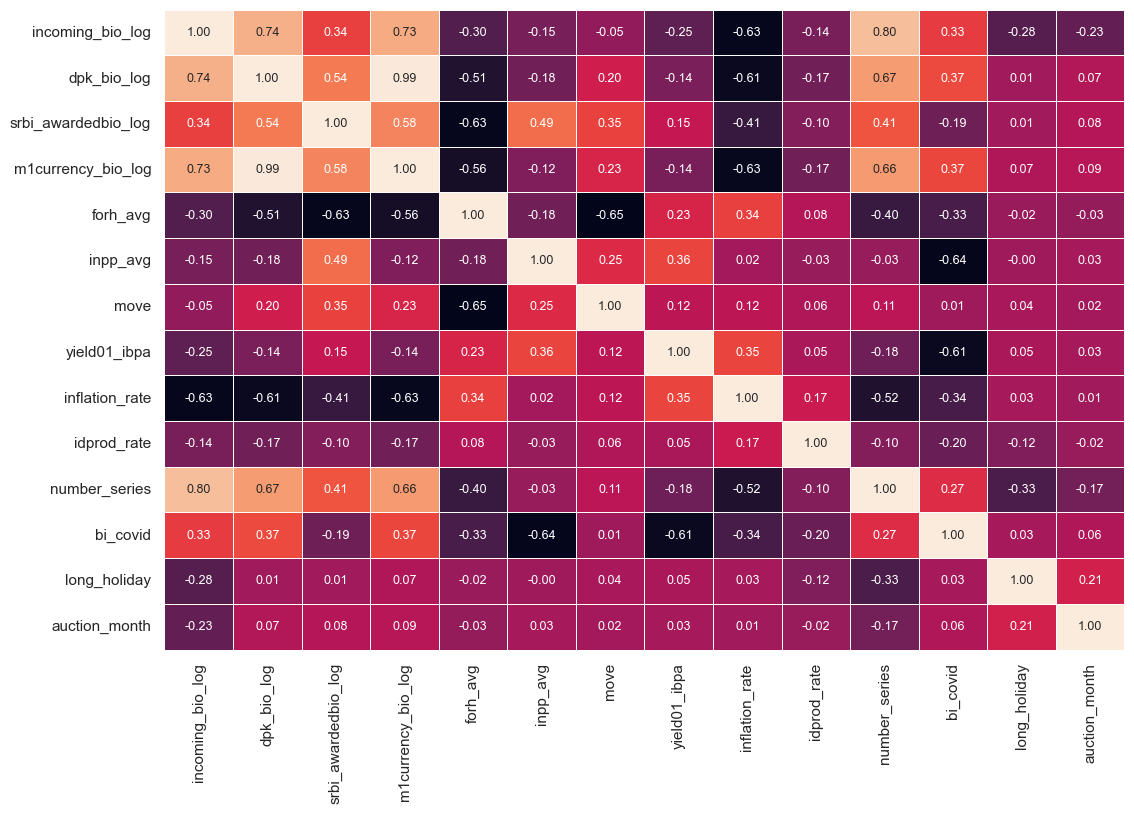

In [5]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_heatmap.pdf"

sns.set_theme()

# Exclude some columns from the data (example: excluding columns 'Column1' and 'Column2')
# columns_to_exclude = ['date', 'auction_month', 'auction_year', 'forh_avg_sqr', 'number_series_sqr', 'bi_covid', 'long_holiday', 'awarded_bio_log', 'srbi_way_incoming', 'm1demanddeposits_bio_log', 'jkse_avg', 'idrusd_avg', 'foreign_reserves_log', 'srbi_incomingbio_log', 'bi_rate', 'usfdtr_policyrate', 'srbi_bid_to_cover', 'cbbp_gross_avg', 'spread_bifd', 'bnkp_mon_avg', 'othp_avg', 'bid_to_cover']  # Replace with actual column names to exclude
# data_filtered = data.drop(columns=columns_to_exclude)

# 'dpk_bio_log', 'm1currency_bio_log', 
# 'auction_month', 'yield01_ibpa', 'inflation_rate', 'idprod_rate', 'dpk_bio_log', 'forh_avg', 'forh_avg_sqr', 'inpp_avg', 'move', 'srbi_way_awarded', 'm1currency_bio_log', 'number_series', 'bi_covid', 'long_holiday', 'srbi_awardedbio_log'

columns_to_include = ['incoming_bio_log', 'dpk_bio_log', 'srbi_awardedbio_log', 'm1currency_bio_log', 'forh_avg', 'inpp_avg', 'move', 'yield01_ibpa', 'inflation_rate', 'idprod_rate', 'number_series', 'bi_covid', 'long_holiday', 'auction_month']
data_filtered = data[columns_to_include]

# Set the theme for the heatmap
sns.set_theme()

# Create the plot
f, ax = plt.subplots(figsize=(12, 8))  # Define the aspect ratio here
# heatmap = sns.heatmap(data_filtered.corr(), annot=True, fmt=".2f", linewidths=.5, ax=ax, annot_kws={"size": 9})
heatmap = sns.heatmap(data_filtered.corr(), annot=True, fmt=".2f", linewidths=.5, ax=ax, annot_kws={"size": 9}, cbar=False)

# # Adjust colorbar font size
# cbar = heatmap.collections[0].colorbar
# cbar.ax.tick_params(labelsize=9)

# Adjust axis label font size
ax.set_xlabel(ax.get_xlabel(), fontsize=9)
ax.set_ylabel(ax.get_ylabel(), fontsize=9)

# Adjust plot margins
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot with the exact dimensions to a PDF
plt.savefig(filename, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Regression

In [6]:
# # Exclude some columns from the data (example: excluding columns 'Column1' and 'Column2')
# columns_to_exclude = ['date', 'auction_month', 'auction_year', 'jkse_avg', 'forh_avg_sqr', 'number_series_sqr', 'bi_covid', 'long_holiday', 'inflation_rate', 'bnkp_mon_avg', 'othp_avg', 'foreign_reserves_log', 'awarded_bio_log', 'srbi_incomingbio_log', 'srbi_way_incoming', 'dpk_bio_log', 'srbi_bid_to_cover', 'm1currency_bio_log', 'm1demanddeposits_bio_log']  # Replace with actual column names to exclude
# data_filtered = data.drop(columns=columns_to_exclude)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      185 non-null    datetime64[ns]
 1   auction_month             185 non-null    int64         
 2   auction_year              185 non-null    int64         
 3   bi_rate                   185 non-null    float64       
 4   spread_bifd               185 non-null    float64       
 5   yield10_ibpa              185 non-null    float64       
 6   inflation_rate            185 non-null    float64       
 7   idprod_rate               185 non-null    float64       
 8   jkse_avg                  185 non-null    float64       
 9   idrusd_avg                185 non-null    float64       
 10  foreign_reserves_log      185 non-null    float64       
 11  dpk_bio_log               185 non-null    float64       
 12  bnkp_mon_avg          

In [7]:
# columns_to_exclude = ['date', 'auction_month', 'auction_year', 'jkse_avg', 'forh_avg_sqr', 'number_series_sqr', 'bi_covid', 'long_holiday', 'inflation_rate', 'bnkp_mon_avg', 'othp_avg', 'foreign_reserves_log', 'awarded_bio_log', 'srbi_incomingbio_log', 'srbi_way_incoming', 'dpk_bio_log', 'srbi_bid_to_cover', 'm1currency_bio_log', 'm1demanddeposits_bio_log']  # Replace with actual column names to exclude

# 'm2all_bio_log', 'm1all_bio_log', 'm2securities_bio_log',

# Define the feature columns and target column
feature_columns = ['dpk_bio_log', 'srbi_awardedbio_log', 'm1currency_bio_log', 'forh_avg', 'inpp_avg', 'move', 'yield01_ibpa', 'inflation_rate', 'idprod_rate', 'number_series', 'bi_covid', 'long_holiday', 'auction_month']
target_column = 'incoming_bio_log'

In [8]:
# Split the data into features (X) and target (y)
X = data[feature_columns]
y = data[target_column]

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Ensure feature_columns matches the features in X_train
feature_columns = list(X_train.columns)  # Use the original feature names

# Convert scaled data back to DataFrame with correct indices and columns
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

# Assume X_train_scaled is your features array and y_train is your target array
model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()  # Add constant automatically
print(model.summary())

# nonrobust w/o ....fit(cov_type='HC0')

                            OLS Regression Results                            
Dep. Variable:       incoming_bio_log   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     45.88
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           7.50e-43
Time:                        10:15:50   Log-Likelihood:                 61.877
No. Observations:                 148   AIC:                            -95.75
Df Residuals:                     134   BIC:                            -53.79
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.9285    

In [12]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_ols.pdf"

# Ensure feature_columns matches the features in X_train
feature_columns = list(X_train.columns)  # Use the original feature names

# Convert scaled data back to DataFrame with correct indices and columns
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

# Assume X_train_scaled is your features array and y_train is your target array
model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit(cov_type='HC0')  # Add constant automatically
print(model.summary())

# Get the model summary as text
summary_text = model.summary().as_text()

# Save summary text to a PDF
with PdfPages(filename) as pdf:
    # Create a new figure with specific size
    plt.figure(figsize=(12, 8))

    # Add text to the figure
    plt.text(0.1, 0.9, summary_text, {'fontsize': 9}, fontproperties='monospace', wrap=True)  # Adjust positions here

    # Hide axes
    plt.axis('off')

    # Adjust margins
    plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)  # Fine-tune margins

    # Save the figure to the PDF
    pdf.savefig()
    plt.close()


                            OLS Regression Results                            
Dep. Variable:       incoming_bio_log   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     41.15
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           2.44e-40
Time:                        10:15:58   Log-Likelihood:                 61.877
No. Observations:                 148   AIC:                            -95.75
Df Residuals:                     134   BIC:                            -53.79
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.9285    

In [13]:
def stepwise_selection(X, y, threshold_in=0.09, threshold_out=0.09):
    included = []
    while True:
        changed = False
        
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [col]])).fit()
            new_pval[col] = model.pvalues[col]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
        
        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        
        if not changed:
            break
    
    return included

# Apply stepwise regression
selected_features = stepwise_selection(X_train, y_train)
X_train_stepwise = X_train[selected_features]
X_test_stepwise = X_test[selected_features]

# Fit the model with selected features
stepwise_model = sm.OLS(y_train, sm.add_constant(X_train_stepwise)).fit()
stepwise_preds = stepwise_model.predict(sm.add_constant(X_test_stepwise))


In [14]:
# def stepwise_selection(X, y, mandatory_features=[], threshold_in=0.01, threshold_out=0.01):
#     included = list(mandatory_features)  # Start with mandatory features
#     while True:
#         changed = False
#         # Forward step
#         excluded = list(set(X.columns) - set(included))
#         new_pval = pd.Series(index=excluded)
#         for col in excluded:
#             model = sm.OLS(y, sm.add_constant(X[included + [col]])).fit()
#             new_pval[col] = model.pvalues[col]
#         best_pval = new_pval.min()
#         if best_pval < threshold_in:
#             best_feature = new_pval.idxmin()
#             included.append(best_feature)
#             changed = True
#         # Backward step
#         model = sm.OLS(y, sm.add_constant(X[included])).fit()
#         pvalues = model.pvalues.iloc[1:]  # Exclude intercept
#         worst_pval = pvalues.max()
#         if worst_pval > threshold_out:
#             worst_feature = pvalues.idxmax()
#             if worst_feature not in mandatory_features:  # Do not remove mandatory features
#                 included.remove(worst_feature)
#                 changed = True
#         if not changed:
#             break
#     return included

# # Apply stepwise regression with mandatory features
# mandatory_features = ['bi_covid']  # Replace with your mandatory features
# selected_features = stepwise_selection(X_train, y_train, mandatory_features=mandatory_features)
# X_train_stepwise = X_train[selected_features]
# X_test_stepwise = X_test[selected_features]

# # Fit the model with selected features
# stepwise_model = sm.OLS(y_train, sm.add_constant(X_train_stepwise)).fit(cov_type='HC0')
# stepwise_preds = stepwise_model.predict(sm.add_constant(X_test_stepwise))

# print(stepwise_model.summary())

In [14]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_stepwise.pdf"

# Ensure feature_columns matches the features in X_train
feature_columns = list(X_train.columns)  # Use the original feature names

# Convert scaled data back to DataFrame with correct indices and columns
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

# Stepwise regression
resulting_features = stepwise_selection(X_train_scaled, y_train)

# Final model (add constant here, don't add 'const' manually); with robust covariance type
final_model = sm.OLS(y_train, sm.add_constant(X_train_scaled[resulting_features])).fit(cov_type='HC0')

print(final_model.summary())

# Get the model summary as text
summary_text_stepwise = final_model.summary().as_text()

# Save summary text to a PDF
with PdfPages(filename) as pdf:
    # Create a new figure
    plt.figure(figsize=(12, 8))
    plt.text(0.01, 0.05, summary_text_stepwise, {'fontsize': 9}, fontproperties='monospace')
    plt.axis('off')
    plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)  # Fine-tune margins
    pdf.savefig()  # Save the current figure
    plt.close()


                            OLS Regression Results                            
Dep. Variable:       incoming_bio_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     79.57
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           8.45e-43
Time:                        10:16:31   Log-Likelihood:                 59.554
No. Observations:                 148   AIC:                            -105.1
Df Residuals:                     141   BIC:                            -84.13
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.9285      0.013    370.

In [15]:
# Multicollinearity Test

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = sm.add_constant(X_train_scaled[resulting_features])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

# Interpretation: Variance Inflation Factor (VIF) values greater than 10 (or sometimes 5) suggest multicollinearity among features.

         Variable       VIF
0           const  1.000000
1   number_series  2.525709
2     dpk_bio_log  2.710194
3            move  1.143156
4   auction_month  1.145392
5    long_holiday  1.259437
6  inflation_rate  1.849528


In [16]:
# Heteroskedasticity Test

import statsmodels.stats.api as sms

# Perform Breusch-Pagan test
bp_test = sms.het_breuschpagan(final_model.resid, final_model.model.exog)
bp_test_results = dict(zip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], bp_test))

print(bp_test_results)

# The results you provided are from the Breusch-Pagan test for heteroskedasticity. Here’s a breakdown of what each value means:

# Lagrange Multiplier Statistic: This is the test statistic for the Breusch-Pagan test. It measures whether the variance of the residuals from a regression is dependent on the values of the independent variables. In your case, the value is approximately 7.997.

# p-value: This is the probability of observing the test statistic under the null hypothesis. The null hypothesis for the Breusch-Pagan test is that there is no heteroskedasticity (i.e., the variance of the residuals is constant). A high p-value (typically greater than 0.05) indicates that we fail to reject the null hypothesis. In your case, the p-value is approximately 0.238, which suggests that there is no significant evidence of heteroskedasticity.

# f-value: This is the F-statistic for the Breusch-Pagan test. It is used to test the overall significance of the regression model. In your case, the F-statistic is approximately 1.343.

# f p-value: This is the p-value associated with the F-statistic. Similar to the p-value for the Lagrange Multiplier Statistic, a high f p-value (typically greater than 0.05) indicates that we fail to reject the null hypothesis. In your case, the f p-value is approximately 0.243, which again suggests that there is no significant evidence of heteroskedasticity.

# Based on these results, you can conclude that there is no significant evidence of heteroskedasticity in your regression model. This means that the variance of the residuals is likely constant, which is a good sign for the validity of your model.

{'Lagrange multiplier statistic': 6.014399026485058, 'p-value': 0.4215790261651608, 'f-value': 0.9954416233288568, 'f p-value': 0.4308603129676444}


In [17]:
# Normality Test of Residuals

from scipy.stats import jarque_bera

# Perform Jarque-Bera test
jb_test = jarque_bera(final_model.resid)
jb_test_results = dict(zip(['JB statistic', 'p-value', 'skew', 'kurtosis'], jb_test))

print(jb_test_results)

# The results you provided are from the Jarque-Bera test for normality of residuals. Here’s a breakdown of what each value means:

# JB Statistic: This is the test statistic for the Jarque-Bera test. It measures the difference of the skewness and kurtosis of the sample data from that of a normal distribution. In your case, the JB statistic is approximately 2.151.

# p-value: This is the probability of observing the test statistic under the null hypothesis. The null hypothesis for the Jarque-Bera test is that the residuals are normally distributed. A high p-value (typically greater than 0.05) indicates that we fail to reject the null hypothesis. In your case, the p-value is approximately 0.341, which suggests that there is no significant evidence against the normality of the residuals.

# Summary
# Based on these results, you can conclude that there is no significant evidence to suggest that the residuals of your regression model deviate from normality. This is a good sign, as normality of residuals is one of the assumptions of linear regression.


{'JB statistic': 1.81513657180522, 'p-value': 0.40350423893886833}


In [18]:
# Autocorrelation Test

from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_test = durbin_watson(final_model.resid)

print(f'Durbin-Watson statistic: {dw_test}')

# The Durbin-Watson statistic is used to detect the presence of autocorrelation (a relationship between values separated from each other by a given time lag) in the residuals from a regression analysis. Here’s a breakdown of what the value means:

# Durbin-Watson Statistic
# Range: The Durbin-Watson statistic ranges from 0 to 4.
# A value of 2 indicates no autocorrelation.
# A value closer to 0 indicates positive autocorrelation.
# A value closer to 4 indicates negative autocorrelation.
# Interpretation of Your Result
# Durbin-Watson statistic: 1.615
# This value is close to 2, which suggests that there is little to no autocorrelation in the residuals of your regression model.
# Values between 1.5 and 2.5 are generally considered to indicate no significant autocorrelation.
# Summary
# Based on the Durbin-Watson statistic of approximately 1.615, you can conclude that there is no significant evidence of autocorrelation in the residuals of your regression model. This is a good sign, as the absence of autocorrelation is one of the assumptions of linear regression.


Durbin-Watson statistic: 1.8016363366896917


In [20]:
# Plotting Residuals

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot residuals
# sns.residplot(x=final_model.fittedvalues, y=final_model.resid, lowess=True, line_kws={'color': 'red'})
# plt.xlabel('Fitted values')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Fitted values')
# plt.show()

# # Plot Q-Q plot
# import statsmodels.api as sm

# sm.qqplot(final_model.resid, line='45')
# plt.title('Q-Q plot')
# plt.show()

In [19]:
# Model Specification Test

from statsmodels.stats.diagnostic import linear_reset

# Ramsey RESET test
reset_test = linear_reset(final_model, power=2, use_f=True)
print(f"RESET test F-statistic: {reset_test.fvalue}, p-value: {reset_test.pvalue}")

# With an F-statistic of 0.5313 and a p-value of 0.4674, the test indicates no evidence of misspecification in the model. This means the functional form appears correct, and there is no strong need to include additional polynomial or interaction terms in the current specification.


RESET test F-statistic: 0.0394565435942709, p-value: 0.8428351025166654


In [22]:
# Outliers and Leverage Points

# from statsmodels.graphics.regressionplots import plot_leverage_resid2
# from statsmodels.stats.outliers_influence import OLSInfluence

# # Leverage-residual plot
# plot_leverage_resid2(final_model)
# plt.show()

# # Cook's distance
# influence = OLSInfluence(final_model)
# cooks_d = influence.cooks_distance[0]
# print("Cook's distance for each observation:")
# print(cooks_d)

# Machine learning

In [20]:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:       incoming_bio_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     79.57
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           8.45e-43
Time:                        10:18:21   Log-Likelihood:                 59.554
No. Observations:                 148   AIC:                            -105.1
Df Residuals:                     141   BIC:                            -84.13
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.9285      0.013    370.

In [59]:
# Define the feature columns and target column
feature_columns = ['number_series', 'dpk_bio_log', 'move', 'auction_month', 'long_holiday', 'inflation_rate']
target_column = 'incoming_bio_log'

# Split the data into features (X) and target (y)
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure feature_columns matches the features in X_train
feature_columns = list(X_train.columns)  # Use the original feature names

# Convert scaled data back to DataFrame with correct indices and columns
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

In [60]:
# Initialize models with their default or tuned parameters
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    # Uncomment if Lasso regression needs to be used
    # "Lasso Regression": Lasso(alpha=0.01),
    "Deep Learning": Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
}

# Compile the Deep Learning model
models["Deep Learning"].compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback for Deep Learning
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

/Users/arifpras/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
# Train and evaluate models
results = {}
r2_scores = {}
predictions_df = pd.DataFrame({'Actual': y_test.values}, index=y_test.index)

# Convert scaled data back to DataFrame with correct indices and columns
feature_columns = list(X_train.columns)  # Use the original feature names
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

# Train and evaluate Scikit-learn models and Deep Learning model
for model_name, model in models.items():
    if model_name == "Deep Learning":
        # Train the Deep Learning model
        model.fit(
            X_train_scaled, y_train,
            validation_split=0.2, epochs=200, batch_size=32,
            callbacks=[early_stopping], verbose=0
        )
        y_pred = model.predict(X_test_scaled).flatten()
    else:
        # Train Scikit-learn models
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled).flatten()
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = mse
    r2_scores[model_name] = r2
    predictions_df[model_name] = y_pred

# Stepwise Regression
resulting_features = stepwise_selection(X_train_scaled, y_train)

# Handle Stepwise Regression separately
stepwise_model = sm.OLS(y_train, sm.add_constant(X_train_scaled[resulting_features]))
stepwise_fit = stepwise_model.fit(cov_type='HC0')

# Ensure the constant column is added only once
X_test_stepwise = sm.add_constant(X_test_scaled[resulting_features], has_constant='add')
y_pred_stepwise = stepwise_fit.predict(X_test_stepwise)

# Calculate performance metrics for Stepwise Regression
mse_stepwise = mean_squared_error(y_test, y_pred_stepwise)
r2_stepwise = r2_score(y_test, y_pred_stepwise)
results["Stepwise Regression"] = mse_stepwise
r2_scores["Stepwise Regression"] = r2_stepwise
predictions_df["Stepwise Regression"] = y_pred_stepwise

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35b50b9c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [62]:
# Sort the models from highest R-squared to lowest
sorted_results = sorted(results.items(), key=lambda x: r2_scores[x[0]], reverse=True)

# Display sorted results
for model_name, mse in sorted_results:
    print(f"{model_name}: MSE = {mse:.4f}, R-squared = {r2_scores[model_name]:.4f}")

# Find the best model based on Mean Squared Error
best_model_name = min(results, key=results.get)
best_model_mse = results[best_model_name]
best_model_r2 = r2_scores[best_model_name]

print(f"\nThe best model is {best_model_name} with MSE = {best_model_mse:.4f} and R-squared = {best_model_r2:.4f}.")

Gradient Boosting: MSE = 0.0240, R-squared = 0.7626
AdaBoost: MSE = 0.0241, R-squared = 0.7615
Linear Regression: MSE = 0.0244, R-squared = 0.7588
Stepwise Regression: MSE = 0.0244, R-squared = 0.7588
Random Forest: MSE = 0.0248, R-squared = 0.7545
Deep Learning: MSE = 0.0971, R-squared = 0.0398

The best model is Gradient Boosting with MSE = 0.0240 and R-squared = 0.7626.


In [63]:
%%capture

import random

# Define parameter grids for tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    # "Gradient Boosting": {
    #     'n_estimators': [100, 150, 200],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'max_depth': [3, 5, 7],
    #     'subsample': [0.8, 1.0]
    # },
    "AdaBoost": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    "Linear Regression": {
        # Linear Regression doesn't have hyperparameters to tune
    },
    # "Lasso Regression": {
    #     'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    #     'max_iter': [1000, 5000, 10000]
    # }
}

# Stepwise Regression (No hyperparameter tuning required)
def run_stepwise_regression(X_train, y_train, X_test):
    # Perform stepwise selection
    resulting_features = stepwise_selection(X_train, y_train)
    
    # Fit the model
    stepwise_model = sm.OLS(y_train, sm.add_constant(X_train[resulting_features]))
    stepwise_fit = stepwise_model.fit(cov_type='HC0')
    
    # Prepare test data
    X_test_stepwise = sm.add_constant(X_test[resulting_features], has_constant='add')
    
    # Predict
    y_pred_stepwise = stepwise_fit.predict(X_test_stepwise)
    return stepwise_fit, y_pred_stepwise, resulting_features

# Train and evaluate models
tuned_models = {}
results = {}
r2_scores = {}
predictions_df = pd.DataFrame({'Actual': y_test.values}, index=y_test.index)

# Train and evaluate Scikit-learn models and Deep Learning model
for model_name, model in models.items():
    if model_name in param_grids:
        grid_search = GridSearchCV(
            model, 
            param_grids[model_name], 
            cv=5, 
            scoring='neg_mean_squared_error', 
            verbose=1
        )
        grid_search.fit(X_train_scaled, y_train)
        tuned_model = grid_search.best_estimator_
        tuned_models[model_name] = tuned_model
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        tuned_model = model
        tuned_models[model_name] = tuned_model
    
    # Train and predict
    tuned_model.fit(X_train_scaled, y_train)
    y_pred = tuned_model.predict(X_test_scaled).flatten()
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = mse
    r2_scores[model_name] = r2
    predictions_df[model_name] = y_pred

# Set random seed for reproducibility
# Set the random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)  # Numpy random seed
tf.random.set_seed(random_seed)  # TensorFlow random seed
random.seed(random_seed)  # Python random seed

# Define Deep Learning model
deep_learning_model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
deep_learning_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Add Deep Learning model evaluation
deep_learning_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2, epochs=300, batch_size=64,
    callbacks=[early_stopping, lr_schedule], verbose=1
)
y_pred_dl = deep_learning_model.predict(X_test_scaled).flatten()
results["Deep Learning"] = mean_squared_error(y_test, y_pred_dl)
r2_scores["Deep Learning"] = r2_score(y_test, y_pred_dl)
predictions_df["Deep Learning"] = y_pred_dl

# Stepwise Regression
stepwise_fit, y_pred_stepwise, resulting_features = run_stepwise_regression(
    X_train_scaled, y_train, X_test_scaled
)

# Evaluate Stepwise Regression
mse_stepwise = mean_squared_error(y_test, y_pred_stepwise)
r2_stepwise = r2_score(y_test, y_pred_stepwise)
results["Stepwise Regression"] = mse_stepwise
r2_scores["Stepwise Regression"] = r2_stepwise
predictions_df["Stepwise Regression"] = y_pred_stepwise

# Print final results
print("Model Performance (MSE):", results)
print("Model Performance (R^2):", r2_scores)

In [64]:
# Sort the models from highest R-squared to lowest
sorted_results = sorted(results.items(), key=lambda x: r2_scores[x[0]], reverse=True)

# Display sorted results
for model_name, mse in sorted_results:
    print(f"{model_name}: MSE = {mse:.4f}, R-squared = {r2_scores[model_name]:.4f}")

# Find the best model based on Mean Squared Error
best_model_name = min(results, key=results.get)
best_model_mse = results[best_model_name]
best_model_r2 = r2_scores[best_model_name]

print(f"\nThe best model is {best_model_name} with MSE = {best_model_mse:.4f} and R-squared = {best_model_r2:.4f}.")

Random Forest: MSE = 0.0227, R-squared = 0.7753
AdaBoost: MSE = 0.0233, R-squared = 0.7697
Gradient Boosting: MSE = 0.0240, R-squared = 0.7626
Linear Regression: MSE = 0.0244, R-squared = 0.7588
Stepwise Regression: MSE = 0.0244, R-squared = 0.7588
Deep Learning: MSE = 0.2298, R-squared = -1.2717

The best model is Random Forest with MSE = 0.0227 and R-squared = 0.7753.


In [66]:
# Define the feature columns and target column
feature_columns = ['number_series', 'dpk_bio_log', 'move', 'auction_month', 'long_holiday', 'inflation_rate']
target_column = 'incoming_bio_log'

# Split the data into features (X) and target (y)
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure feature_columns matches the features in X_train
feature_columns = list(X_train.columns)  # Use the original feature names

# Convert scaled data back to DataFrame with correct indices and columns
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feature_columns)

# List of variable names in the same order as the features
variable_names = ['number_series', 'dpk_bio_log', 'move', 'auction_month', 'long_holiday', 'inflation_rate']

feature_importances = {}
for name, model in tuned_models.items():
    if name == "Deep Learning":
        model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    else:
        model.fit(X_train_scaled, y_train)
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_

# Calculate feature importance for linear regression model
coef = tuned_models["Linear Regression"].coef_
feature_importances["Linear Regression"] = np.abs(coef) / np.sum(np.abs(coef))

# Aggregate feature importances from all models
avg_feature_importance = np.mean([imp for imp in feature_importances.values()], axis=0)

# Sort features by their average importance
sorted_indices = np.argsort(avg_feature_importance)[::-1]
sorted_features = [(i, avg_feature_importance[i]) for i in sorted_indices]

# Ensure that the number of variable names matches the number of features
if len(variable_names) != len(sorted_features):
    raise ValueError("The number of variable names does not match the number of features.")

# Label each feature with its variable name
labeled_features = [(variable_names[idx], importance) for idx, importance in sorted_features]

# Print labeled features by importance
print("Features sorted by importance (most to least):")
for name, importance in labeled_features:
    print(f"{name}: {importance}")

# Determine the relationship of each feature with the target variable using Linear Regression coefficients
relationships = ["positive" if coef[i] > 0 else "negative" for i in sorted_indices]

# Print the relationship of each feature with the target variable
print("\nRelationship of each feature with the target variable:")
for name, relationship in zip([variable_names[i] for i in sorted_indices], relationships):
    print(f"{name}: {relationship}")

# Visualize the relationships and importance of each variable

# Extract feature names and their importance
feature_names = [name for name, _ in labeled_features]
feature_importance = [importance for _, importance in labeled_features]

Features sorted by importance (most to least):
number_series: 0.40453035720351593
dpk_bio_log: 0.34019844845887376
inflation_rate: 0.08701577561355356
auction_month: 0.08324400947027198
move: 0.054318243273019845
long_holiday: 0.0306931659807649

Relationship of each feature with the target variable:
number_series: positive
dpk_bio_log: positive
inflation_rate: negative
auction_month: negative
move: negative
long_holiday: negative


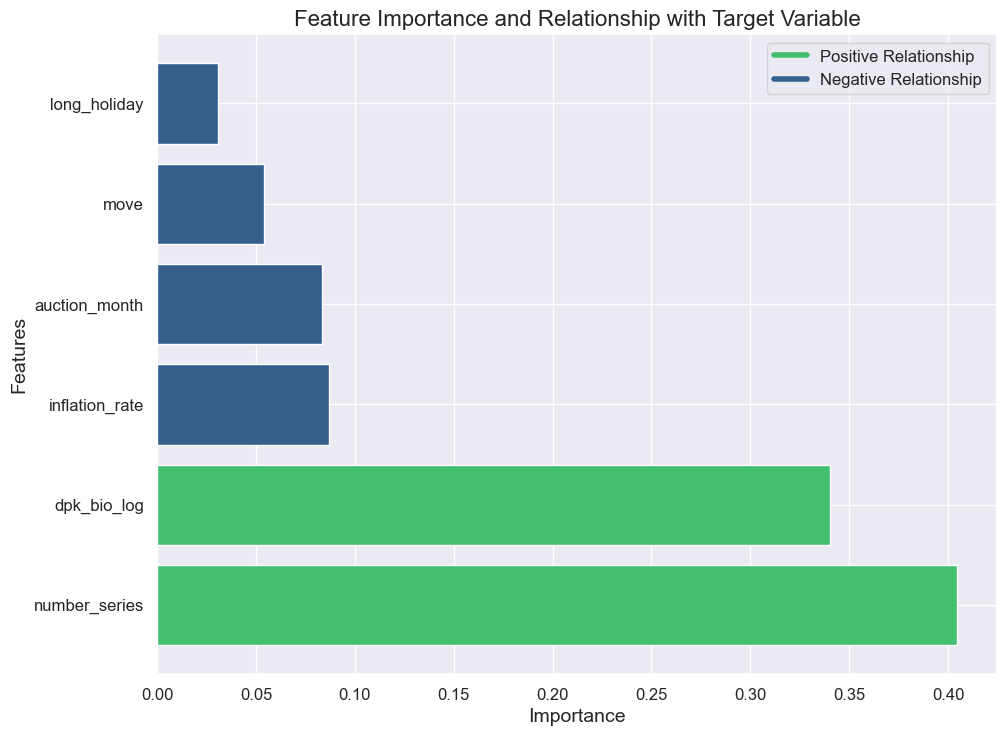

The plot has been saved to 20251208_1334_feature.pdf.


In [67]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_feature.pdf"

# Reset Matplotlib to default parameters
plt.rcdefaults()

# Reset Seaborn again, just to ensure default theme
sns.set_theme(context='notebook', style='darkgrid')

# Increase font sizes
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

# Create a horizontal bar plot for feature relationships
fig, ax = plt.subplots(figsize=(12, 8))

# Use viridis color palette for two discrete colors
cmap = plt.colormaps['viridis']
colors = [cmap(0.7) if rel == 'positive' else cmap(0.3) for rel in relationships]

bars = ax.barh(range(len(feature_names)), feature_importance, color=colors, align='center')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance and Relationship with Target Variable')

# Add legend for colors
positive_patch = plt.Line2D([0], [0], color=cmap(0.7), lw=4, label='Positive Relationship')
negative_patch = plt.Line2D([0], [0], color=cmap(0.3), lw=4, label='Negative Relationship')
plt.legend(handles=[positive_patch, negative_patch])

# # Show the plot
# plt.show()

# Adjust margins
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)  # Fine-tune margins

# Save the plot to a PDF file
with PdfPages(filename) as pdf:
    pdf.savefig(fig)
# plt.close()
plt.show()

print(f"The plot has been saved to {filename}.")

In [68]:
# Display the predictions DataFrame
print(predictions_df.head())

       Actual  Random Forest  Gradient Boosting  AdaBoost  Linear Regression  \
19   4.659670       4.731754           4.745497  4.825688           4.389530   
42   4.533522       4.527640           4.660916  4.520451           4.432596   
156  5.137245       5.165732           5.157737  5.200332           5.113560   
111  4.978017       5.136269           5.153450  5.120318           5.037592   
148  4.897857       5.073405           4.943554  5.054751           5.053266   

     Deep Learning  Stepwise Regression  
19        3.873282             4.389530  
42        4.058352             4.432596  
156       4.680870             5.113560  
111       4.529249             5.037592  
148       4.636906             5.053266  


In [69]:
predictions_df

,Actual,Random Forest,Gradient Boosting,AdaBoost,Linear Regression,Deep Learning,Stepwise Regression
19,4.659670,4.731754,4.745497,4.825688,4.389530,3.873282,4.389530
42,4.533522,4.527640,4.660916,4.520451,4.432596,4.058352,4.432596
156,5.137245,5.165732,5.157737,5.200332,5.113560,4.680870,5.113560
111,4.978017,5.136269,5.153450,5.120318,5.037592,4.529249,5.037592
148,4.897857,5.073405,4.943554,5.054751,5.053266,4.636906,5.053266
15,4.674255,4.547197,4.570519,4.547855,4.572979,4.571820,4.572979
24,4.868239,4.706486,4.759281,4.726098,4.757631,4.838989,4.757631
68,4.589124,4.640315,4.587417,4.640021,4.709364,4.191423,4.709364
117,5.331585,5.152739,5.120986,5.230694,5.149040,4.663473,5.149040
98,4.561738,4.826714,4.799495,4.867479,4.761721,4.330117,4.761721


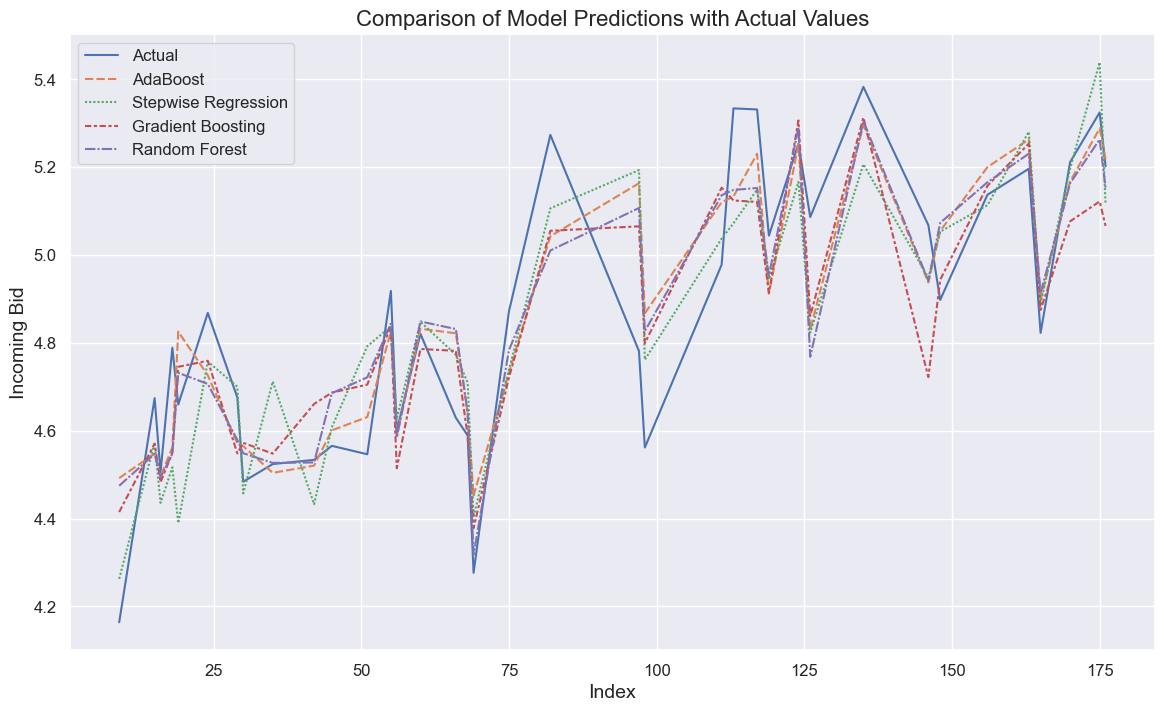

In [70]:
# 1. Line Plot of Actual vs. Predicted Values
# A line plot can help you compare the actual values with the predicted values from different models.

# Assuming predictions_df is the DataFrame containing the actual and predicted values
plt.figure(figsize=(14, 8))
sns.lineplot(data=predictions_df[['Actual', 'AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']])
plt.title('Comparison of Model Predictions with Actual Values')
plt.xlabel('Index')
plt.ylabel('Incoming Bid')
plt.legend(loc='upper left')
plt.show()

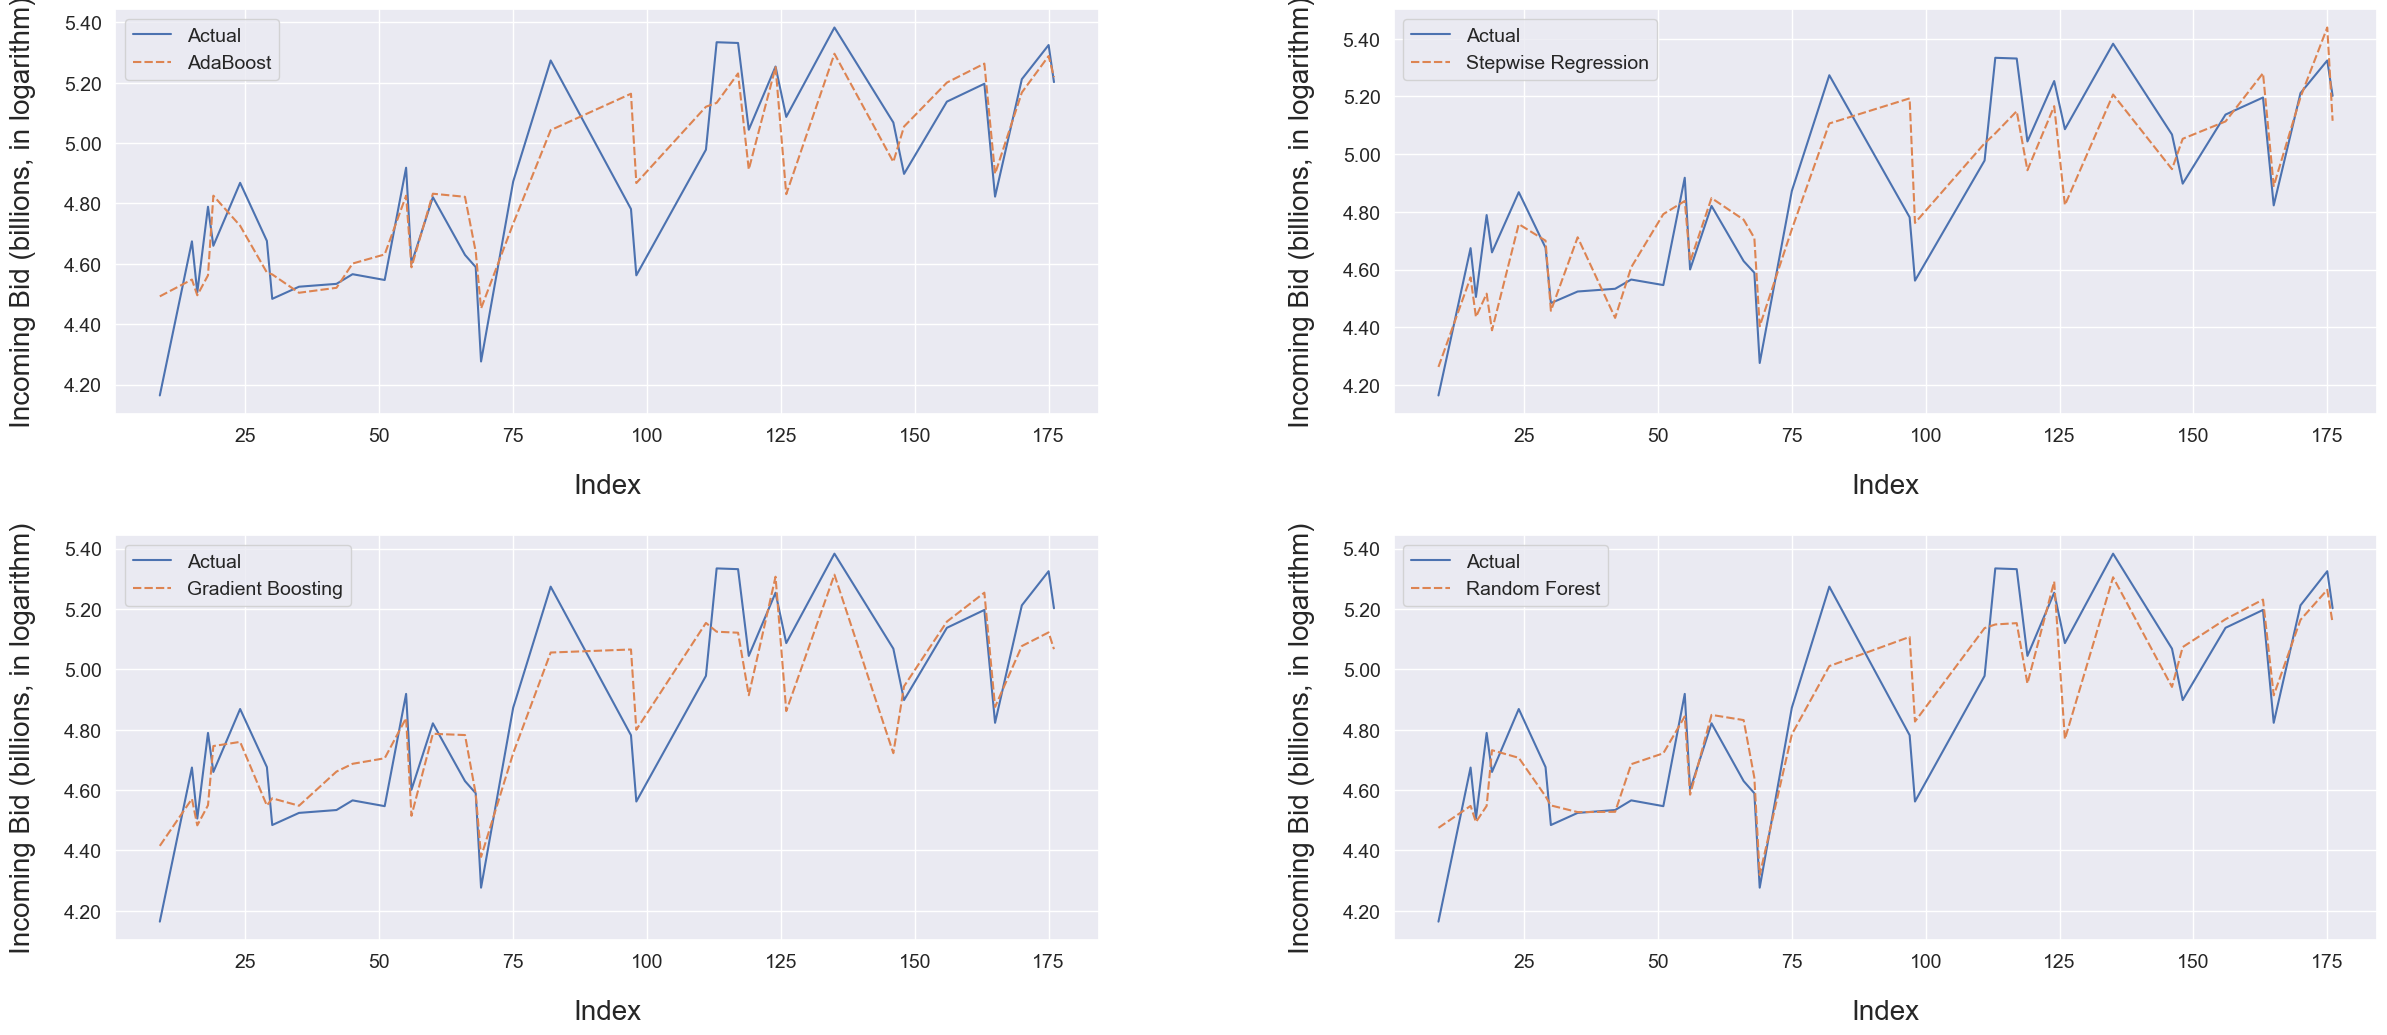

The plot has been saved to 20251208_1334_modelcomparison.pdf.


In [71]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_modelcomparison.pdf"

# Set the Seaborn theme
# sns.set_theme(style="whitegrid")
# sns.reset_defaults()

# Reset Matplotlib to default parameters
plt.rcdefaults()

# Reset Seaborn again, just to ensure default theme
sns.set_theme(context='notebook', style='darkgrid')

# Create a figure with 2 columns x 2 rows of subplots and set the figure size ratio to 12.09 x 29.19 for the whole page
fig, axes = plt.subplots(2, 2, figsize=(29.19, 12.09))

# List of model names for iteration
model_names = ['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']

# Plot each model's predictions against the actual values in separate subplots
for ax, model_name in zip(axes.flatten(), model_names):
    sns.lineplot(data=predictions_df[['Actual', model_name]], ax=ax)
    ax.set_xlabel('Index', fontsize=20, labelpad=20)  # Increase font size twice (default is 12) and add space
    ax.set_ylabel('Incoming Bid (billions, in logarithm)', fontsize=20, labelpad=20)  # Increase font size twice (default is 12) and add space
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))  # Format y-axis in comma format with 2 decimal places
    ax.legend(fontsize=14)  # Increase font size for the legend in each panel

# Adjust the space between panels using plt.subplots_adjust()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the plot to a PDF file
with PdfPages(filename) as pdf:
    pdf.savefig(fig)
# plt.close()
plt.show()

print(f"The plot has been saved to {filename}.")

In [36]:
# # 2. Residual Plot
# # A residual plot shows the difference between the actual and predicted values. It helps to identify patterns in the residuals that might indicate issues with the model.

# plt.figure(figsize=(14, 8))
# for model_name in ['Random Forest', 'Stepwise Regression', 'AdaBoost', 'Gradient Boosting']:
#     sns.residplot(x=predictions_df['Actual'], y=predictions_df[model_name], label=model_name)
# plt.title('Residual Plot')
# plt.xlabel('Actual Values')
# plt.ylabel('Residuals')
# plt.legend(loc='upper right')
# plt.show()

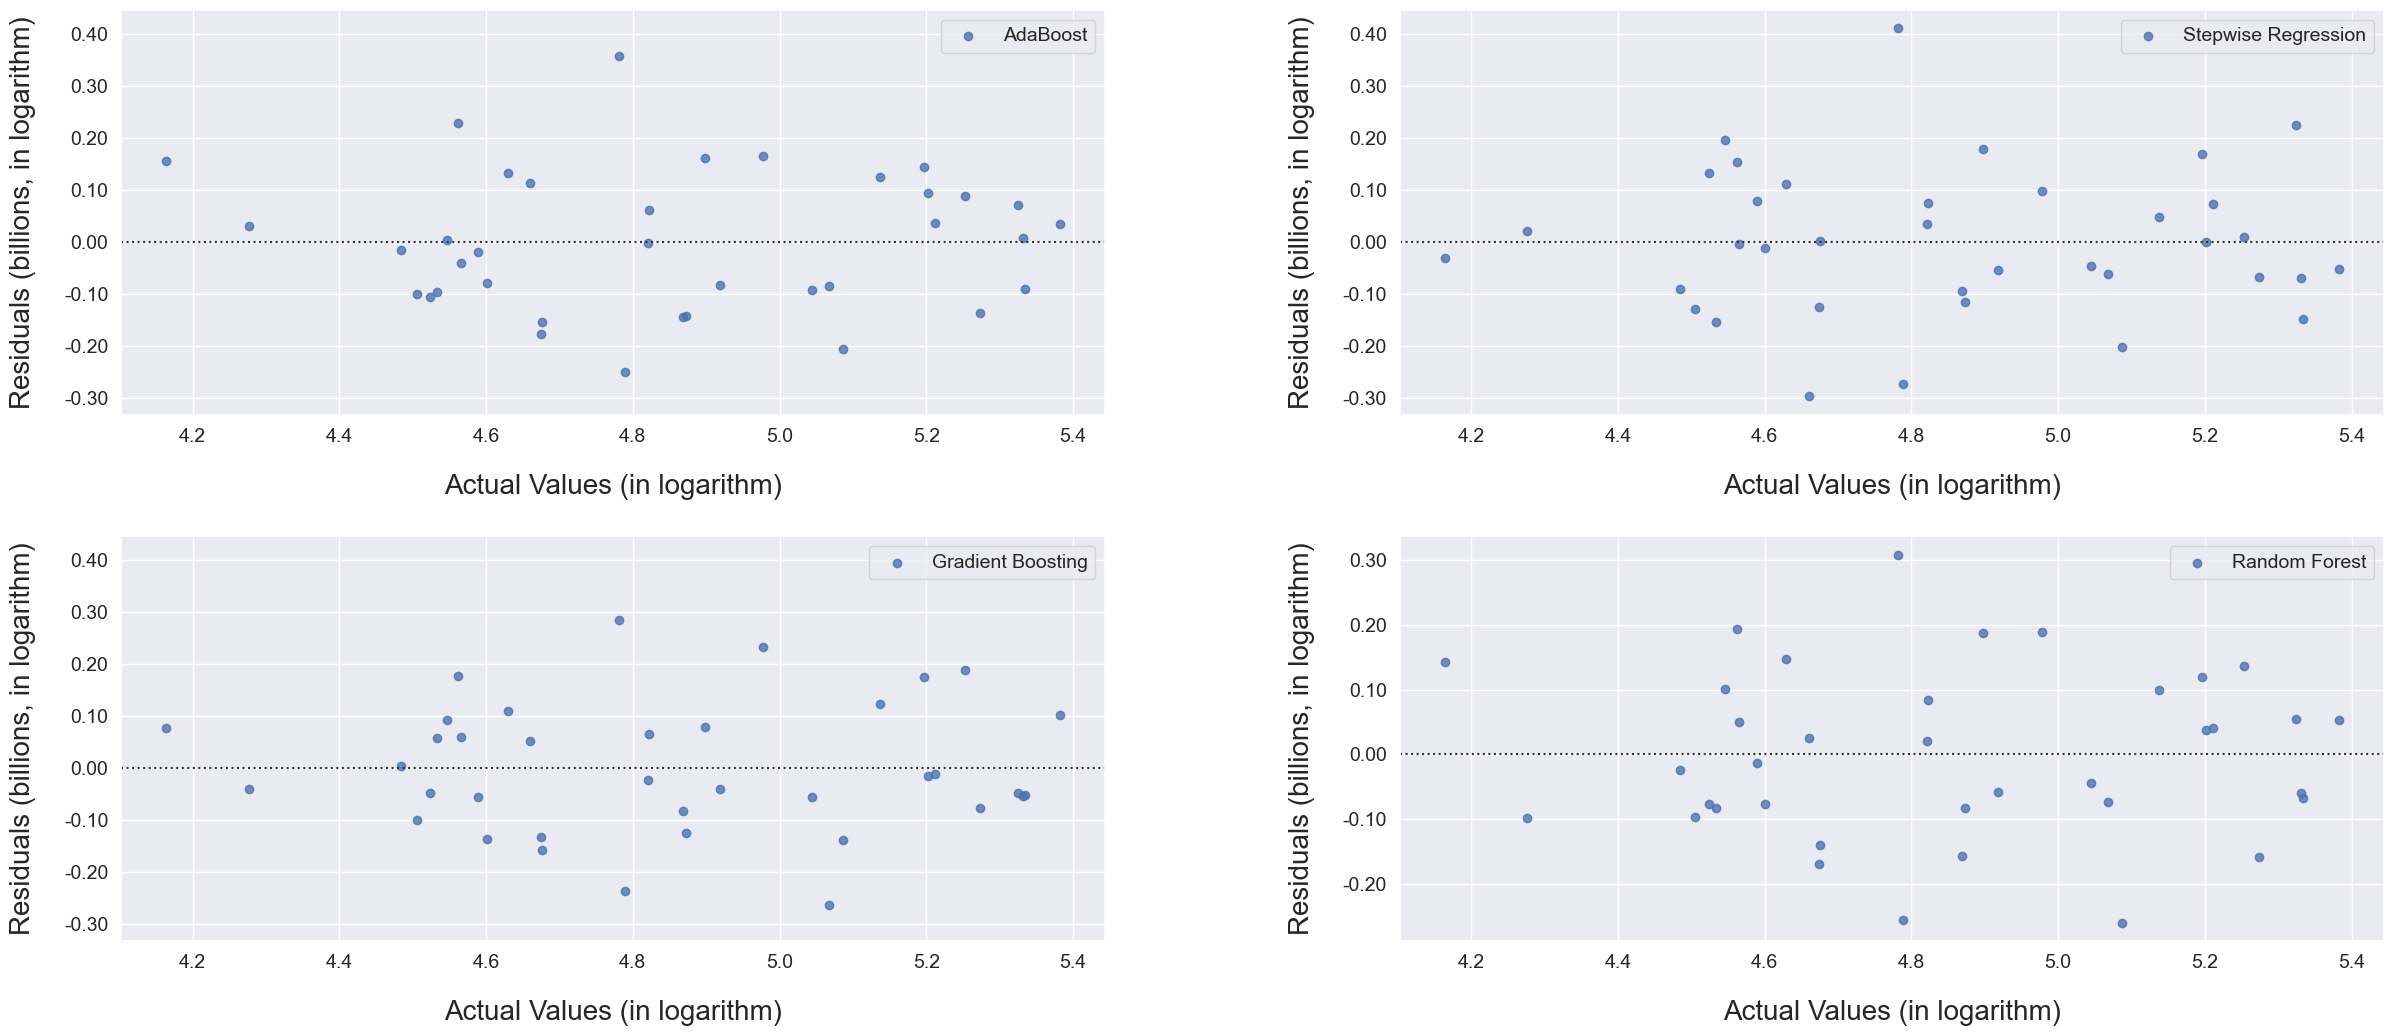

The plot has been saved to 20251208_1334_residuals.pdf.


In [72]:
# Generate the current date and time in the desired format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M")

# Define the filename
filename = f"{formatted_time}_residuals.pdf"

# Create a figure with 3 columns x 2 rows of subplots and set the figure size ratio to 12.09 x 29.19 for the whole page
fig, axes = plt.subplots(2, 2, figsize=(29.19, 12.09))

# List of model names for iteration (excluding the last one for the bottom right panel)
model_names = ['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']

# Plot each model's residuals against the actual values in separate subplots
for ax, model_name in zip(axes.flatten(), model_names):
    sns.residplot(x=predictions_df['Actual'], y=predictions_df[model_name], ax=ax, label=model_name)
    ax.set_xlabel('Actual Values (in logarithm)', fontsize=20, labelpad=20)  # Increase font size twice (default is 12) and add space
    ax.set_ylabel('Residuals (billions, in logarithm)', fontsize=20, labelpad=20)  # Increase font size twice (default is 12) and add space
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))  # Format y-axis in comma format
    ax.legend(fontsize=14)  # Increase font size for the legend in each panel

# # Remove the last panel (bottom right)
# fig.delaxes(axes.flatten()[-1])

# Adjust the space between panels using plt.subplots_adjust()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Ensure the y-axis scale is similar across all subplots
y_min = min(ax.get_ylim()[0] for ax in axes.flatten()[:-1])
y_max = max(ax.get_ylim()[1] for ax in axes.flatten()[:-1])
for ax in axes.flatten()[:-1]:
    ax.set_ylim(y_min, y_max)

# Save the plot to a PDF file
with PdfPages(filename) as pdf:
    pdf.savefig(fig)
# plt.close()
plt.show()

print(f"The plot has been saved to {filename}.")

In [38]:
# # 3. Distribution Plot of Residuals
# # A distribution plot of residuals helps to check if the residuals are normally distributed, which is an assumption of many regression models.

# residuals_df = pd.DataFrame()
# for model_name in ['Random Forest', 'Stepwise Regression', 'AdaBoost', 'Gradient Boosting']:
#     residuals_df[model_name] = predictions_df['Actual'] - predictions_df[model_name]

# residuals_df = residuals_df.melt(var_name='Model', value_name='Residuals')

# g = sns.FacetGrid(residuals_df, col='Model', col_wrap=2, height=4, aspect=1.5)
# g.map(sns.histplot, 'Residuals', kde=True, element='step')
# g.add_legend()
# plt.show()

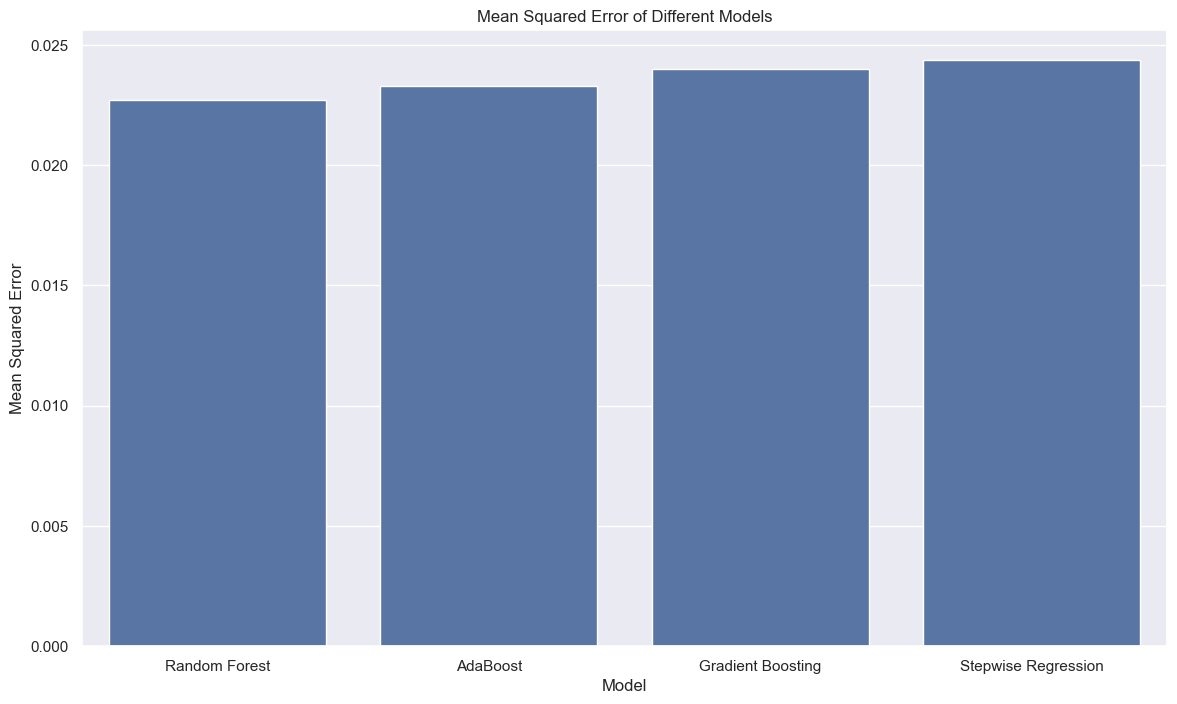

In [73]:
# 4. Mean Squared Error (MSE) Bar Plot
# A bar plot of the Mean Squared Error (MSE) for each model can help you compare the performance of different models quantitatively.

# Selected results
results_selected = ['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']

# Filter the results to include only the selected models
filtered_results = {model: results[model] for model in results_selected}

# Sort filtered results based on the lowest MSE
sorted_filtered_results = sorted(filtered_results.items(), key=lambda x: x[1])
sorted_model_names = [item[0] for item in sorted_filtered_results]
sorted_mse_values = [item[1] for item in sorted_filtered_results]

# Create a bar plot of the Mean Squared Error (MSE) for each model
plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_model_names, y=sorted_mse_values)
plt.title('Mean Squared Error of Different Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.show()


In [40]:
# # 5. Box Plot of Predictions
# # A box plot can help you visualize the distribution of predictions from different models.

# plt.figure(figsize=(14, 8))
# sns.boxplot(data=predictions_df[['Random Forest', 'Stepwise Regression', 'AdaBoost', 'Gradient Boosting']])
# plt.title('Box Plot of Model Predictions')
# plt.xlabel('Model')
# plt.ylabel('Predicted Values')
# plt.show()

In [41]:
# # 6. Scatter Plot of Actual vs. Predicted Values
# # A scatter plot can help you visualize the relationship between actual and predicted values.

# plt.figure(figsize=(14, 8))
# for model_name in ['Random Forest', 'Stepwise Regression', 'AdaBoost', 'Gradient Boosting']:
#     plt.scatter(predictions_df['Actual'], predictions_df[model_name], label=model_name, alpha=0.5)
# plt.plot([predictions_df['Actual'].min(), predictions_df['Actual'].max()], [predictions_df['Actual'].min(), predictions_df['Actual'].max()], 'k--', lw=2)
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.legend(loc='upper left')
# plt.show()

# Predict 2026

In [96]:
# Load the Excel file
file_path = '/Users/arifpras/Library/CloudStorage/OneDrive-Kemenkeu/01_Kemenkeu/cop_podem/20251207_db01.xlsx'

# Specify the sheet name
sheet_name = 'predict_sbn'

# Read the Excel file with the specified sheet
new_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the DataFrame
print(new_data.head())

        date  auction_month  auction_year  bi_rate  spread_bifd  yield10_ibpa  \
0 2025-12-01             12          2025     4.75         0.75      6.122132   
1 2026-01-01              1          2026     4.75         0.75      6.705608   
2 2026-02-01              2          2026     4.75         0.75      7.093853   
3 2026-03-01              3          2026     4.75         0.75      6.914648   
4 2026-04-01              4          2026     4.75         0.75      7.161278   

   inflation_rate  idprod_rate     jkse_avg    idrusd_avg  ...  \
0        2.698297     0.717965  8324.271662  16737.357487  ...   
1        2.394458    -2.753490  8230.134994  16777.859416  ...   
2        2.372964    -6.186241  8245.593918  16817.390906  ...   
3        2.351547    -6.711308  8286.396056  16851.635651  ...   
4        2.330206    -1.961652  8335.419209  16892.664746  ...   

   m1demanddeposits_bio_log  m2quasi_bio_log  m2securities_bio_log  \
0                  6.315977         6.825732  

In [97]:
new_data_scaled = scaler.transform(new_data[feature_columns])

In [98]:
%%capture

# Perform predictions for all models
predictions = {}

# Predict using Scikit-learn models
for model_name, model in tuned_models.items():
    predictions[model_name] = model.predict(new_data_scaled)

# Ensure new_data_scaled is converted to a DataFrame
new_data_scaled_df = pd.DataFrame(new_data_scaled, columns=feature_columns)

# # Stepwise Regression (No hyperparameter tuning required)
# def run_stepwise_regression(X_train, y_train, X_test):
#     # Perform stepwise selection
#     resulting_features = stepwise_selection(X_train, y_train)
    
#     # Fit the model
#     stepwise_model = sm.OLS(y_train, sm.add_constant(X_train[resulting_features]))
#     stepwise_fit = stepwise_model.fit(cov_type='HC0')
    
#     # Prepare test data
#     X_test_stepwise = sm.add_constant(X_test[resulting_features], has_constant='add')
    
#     # Predict
#     y_pred_stepwise = stepwise_fit.predict(X_test_stepwise)
#     return stepwise_fit, y_pred_stepwise, resulting_features

# Filter the features for stepwise regression
new_data_stepwise = sm.add_constant(new_data_scaled_df[resulting_features], has_constant='add')

# Predict using the stepwise regression model
predictions["Stepwise Regression"] = stepwise_fit.predict(new_data_stepwise)

In [99]:
# Create a DataFrame to compare predictions
comparison_df = new_data.copy()
for model_name, preds in predictions.items():
    comparison_df[model_name] = preds

In [79]:
comparison_df

,date,auction_month,auction_year,bi_rate,spread_bifd,yield10_ibpa,inflation_rate,idprod_rate,jkse_avg,idrusd_avg,...,srbi_way_incoming,srbi_way_awarded,yield01_ibpa,yield05_ibpa,Random Forest,Gradient Boosting,AdaBoost,Linear Regression,Deep Learning,Stepwise Regression
0,2025-12-01,12,2025,4.75,0.75,6.122132,2.698297,0.717965,8324.271662,16737.357487,...,4.807293,4.795939,4.693034,5.601202,5.284565,5.167694,5.160046,5.009262,4.597235,5.009262
1,2026-01-01,1,2026,4.75,0.75,6.705608,2.394458,-2.753490,8230.134994,16777.859416,...,4.832681,4.821215,4.689035,5.595155,5.470447,5.526529,5.416993,5.559181,5.504333,5.559181
2,2026-02-01,2,2026,4.75,0.75,7.093853,2.372964,-6.186241,8245.593918,16817.390906,...,4.858259,4.846681,4.684120,5.589011,5.470447,5.520221,5.416993,5.542586,5.487673,5.542586
3,2026-03-01,3,2026,4.75,0.75,6.914648,2.351547,-6.711308,8286.396056,16851.635651,...,4.884021,4.872332,4.679115,5.584690,5.336920,5.302937,5.384870,5.250549,5.068392,5.250549
4,2026-04-01,4,2026,4.75,0.75,7.161278,2.330206,-1.961652,8335.419209,16892.664746,...,4.909960,4.898162,4.674024,5.578169,5.461766,5.480115,5.416993,5.509262,5.464321,5.509262
5,2026-05-01,5,2026,4.75,0.75,7.332127,2.308937,-0.353240,8348.197042,16933.035158,...,4.936073,4.924165,4.668849,5.571751,5.464826,5.480115,5.419502,5.492668,5.470503,5.492668
6,2026-06-01,6,2026,4.75,0.75,6.980167,2.088194,-3.131379,8389.776824,16973.376462,...,4.962352,4.950335,4.663592,5.565245,5.480317,5.521906,5.416465,5.604060,5.683798,5.604060
7,2026-07-01,7,2026,4.75,0.75,7.183556,2.133169,0.084181,8304.668382,17013.689520,...,4.988794,4.976668,4.658256,5.558656,5.480317,5.515698,5.434497,5.462461,5.488473,5.462461
8,2026-08-01,8,2026,4.75,0.75,7.132788,1.901704,-2.175748,8388.400354,17053.975165,...,5.015392,5.003159,4.652843,5.553794,5.486855,5.555486,5.434497,5.449938,5.503065,5.449938
9,2026-09-01,9,2026,4.75,0.75,7.133187,1.590313,-0.060736,8294.102617,17093.713796,...,5.042143,5.029802,4.647355,5.546864,5.461887,5.463916,5.415852,5.562929,5.776638,5.562929


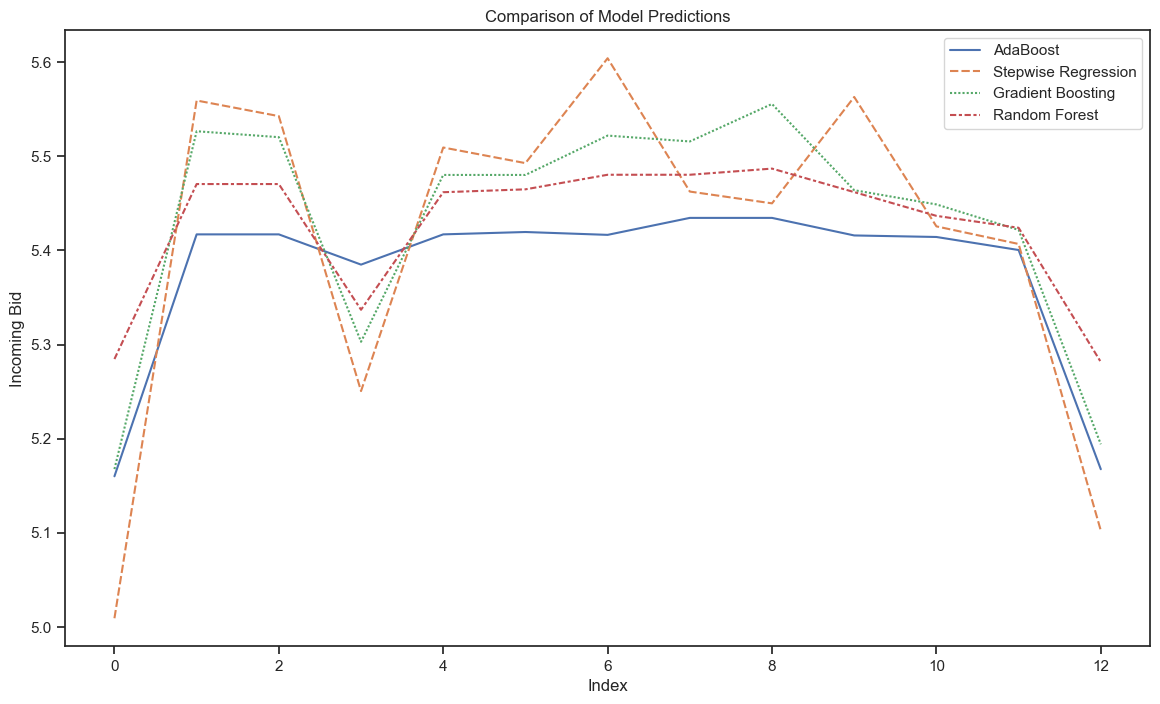

In [100]:
# Visualize the comparison using seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=comparison_df[['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']])
plt.title('Comparison of Model Predictions')
plt.xlabel('Index')
plt.ylabel('Incoming Bid')
plt.legend(loc='upper right')
plt.show()

In [101]:
comparison_df

,date,auction_month,auction_year,bi_rate,spread_bifd,yield10_ibpa,inflation_rate,idprod_rate,jkse_avg,idrusd_avg,...,srbi_way_incoming,srbi_way_awarded,yield01_ibpa,yield05_ibpa,Random Forest,Gradient Boosting,AdaBoost,Linear Regression,Deep Learning,Stepwise Regression
0,2025-12-01,12,2025,4.75,0.75,6.122132,2.698297,0.717965,8324.271662,16737.357487,...,4.807293,4.795939,4.693034,5.601202,5.284565,5.167694,5.160046,5.009262,4.597235,5.009262
1,2026-01-01,1,2026,4.75,0.75,6.705608,2.394458,-2.753490,8230.134994,16777.859416,...,4.832681,4.821215,4.689035,5.595155,5.470447,5.526529,5.416993,5.559181,5.504333,5.559181
2,2026-02-01,2,2026,4.75,0.75,7.093853,2.372964,-6.186241,8245.593918,16817.390906,...,4.858259,4.846681,4.684120,5.589011,5.470447,5.520221,5.416993,5.542586,5.487673,5.542586
3,2026-03-01,3,2026,4.75,0.75,6.914648,2.351547,-6.711308,8286.396056,16851.635651,...,4.884021,4.872332,4.679115,5.584690,5.336920,5.302937,5.384870,5.250549,5.068392,5.250549
4,2026-04-01,4,2026,4.75,0.75,7.161278,2.330206,-1.961652,8335.419209,16892.664746,...,4.909960,4.898162,4.674024,5.578169,5.461766,5.480115,5.416993,5.509262,5.464321,5.509262
5,2026-05-01,5,2026,4.75,0.75,7.332127,2.308937,-0.353240,8348.197042,16933.035158,...,4.936073,4.924165,4.668849,5.571751,5.464826,5.480115,5.419502,5.492668,5.470503,5.492668
6,2026-06-01,6,2026,4.75,0.75,6.980167,2.088194,-3.131379,8389.776824,16973.376462,...,4.962352,4.950335,4.663592,5.565245,5.480317,5.521906,5.416465,5.604060,5.683798,5.604060
7,2026-07-01,7,2026,4.75,0.75,7.183556,2.133169,0.084181,8304.668382,17013.689520,...,4.988794,4.976668,4.658256,5.558656,5.480317,5.515698,5.434497,5.462461,5.488473,5.462461
8,2026-08-01,8,2026,4.75,0.75,7.132788,1.901704,-2.175748,8388.400354,17053.975165,...,5.015392,5.003159,4.652843,5.553794,5.486855,5.555486,5.434497,5.449938,5.503065,5.449938
9,2026-09-01,9,2026,4.75,0.75,7.133187,1.590313,-0.060736,8294.102617,17093.713796,...,5.042143,5.029802,4.647355,5.546864,5.461887,5.463916,5.415852,5.562929,5.776638,5.562929


In [102]:
# List of columns to revert back to decimal from logarithm
columns_to_revert = ['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest', 'Deep Learning' ,'Linear Regression']

# Revert the specified columns back to decimal from logarithm
comparison_df[columns_to_revert] = comparison_df[columns_to_revert].apply(lambda x: 10**x)

# Display the updated DataFrame
print(comparison_df.head())

        date  auction_month  auction_year  bi_rate  spread_bifd  yield10_ibpa  \
0 2025-12-01             12          2025     4.75         0.75      6.122132   
1 2026-01-01              1          2026     4.75         0.75      6.705608   
2 2026-02-01              2          2026     4.75         0.75      7.093853   
3 2026-03-01              3          2026     4.75         0.75      6.914648   
4 2026-04-01              4          2026     4.75         0.75      7.161278   

   inflation_rate  idprod_rate     jkse_avg    idrusd_avg  ...  \
0        2.698297     0.717965  8324.271662  16737.357487  ...   
1        2.394458    -2.753490  8230.134994  16777.859416  ...   
2        2.372964    -6.186241  8245.593918  16817.390906  ...   
3        2.351547    -6.711308  8286.396056  16851.635651  ...   
4        2.330206    -1.961652  8335.419209  16892.664746  ...   

   srbi_way_incoming  srbi_way_awarded  yield01_ibpa  yield05_ibpa  \
0           4.807293          4.795939      4.

In [103]:
# Sort the models from highest R-squared to lowest
sorted_results = sorted(results.items(), key=lambda x: r2_scores[x[0]], reverse=True)

# Display sorted results
for model_name, mse in sorted_results:
    print(f"{model_name}: MSE = {mse:.4f}, R-squared = {r2_scores[model_name]:.4f}")

# Find the best model based on Mean Squared Error
best_model_name = min(results, key=results.get)
best_model_mse = results[best_model_name]
best_model_r2 = r2_scores[best_model_name]

print(f"\nThe best model is {best_model_name} with MSE = {best_model_mse:.4f} and R-squared = {best_model_r2:.4f}.")

Random Forest: MSE = 0.0227, R-squared = 0.7753
AdaBoost: MSE = 0.0233, R-squared = 0.7697
Gradient Boosting: MSE = 0.0240, R-squared = 0.7626
Linear Regression: MSE = 0.0244, R-squared = 0.7588
Stepwise Regression: MSE = 0.0244, R-squared = 0.7588
Deep Learning: MSE = 0.2298, R-squared = -1.2717

The best model is Random Forest with MSE = 0.0227 and R-squared = 0.7753.


In [104]:
# Add "month" variable from Jan. 2026 to Dec. 2026 sequentially
months = pd.date_range(start='2025-12-01', end='2026-12-31', freq='M').strftime('%b %Y')
comparison_df['Month'] = months

print(comparison_df)

         date  auction_month  auction_year  bi_rate  spread_bifd  \
0  2025-12-01             12          2025     4.75         0.75   
1  2026-01-01              1          2026     4.75         0.75   
2  2026-02-01              2          2026     4.75         0.75   
3  2026-03-01              3          2026     4.75         0.75   
4  2026-04-01              4          2026     4.75         0.75   
5  2026-05-01              5          2026     4.75         0.75   
6  2026-06-01              6          2026     4.75         0.75   
7  2026-07-01              7          2026     4.75         0.75   
8  2026-08-01              8          2026     4.75         0.75   
9  2026-09-01              9          2026     4.75         0.75   
10 2026-10-01             10          2026     4.75         0.75   
11 2026-11-01             11          2026     4.75         0.75   
12 2026-12-01             12          2026     4.75         0.75   

    yield10_ibpa  inflation_rate  idprod_rate  

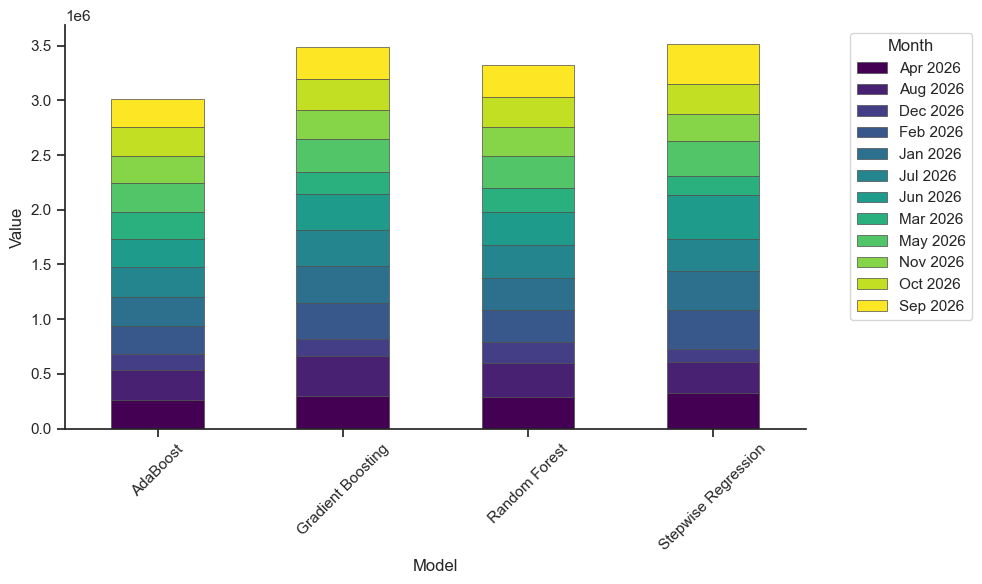

In [105]:
import matplotlib as mpl

df_filtered = comparison_df[comparison_df['Month'] != 'Dec 2025']

# Select only the required columns
comparison_df = df_filtered[['Month', 'AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']]

# comparison_df['Month'] = months[:len(comparison_df)]

# # Melt the dataframe for plotting
# comparison_df_melted = comparison_df.melt(id_vars=['Month'], var_name='Model', value_name='Value')

# # Set the Seaborn theme
# sns.set_theme(style="ticks")

# # Create the plot
# f, ax = plt.subplots(figsize=(7, 5))
# sns.despine(f)

# sns.histplot(
#     comparison_df_melted,
#     x="Value", hue="Model",
#     multiple="stack",
#     palette="light:m_r",
#     edgecolor=".3",
#     linewidth=.5,
#     log_scale=True,
# )

# plt.show()

# # Melt the dataframe for plotting
# comparison_df_melted = comparison_df.melt(id_vars=['Month'], var_name='Model', value_name='Value')

# # Set the Seaborn theme
# sns.set_theme(style="ticks")

# # Create the plot
# f, ax = plt.subplots(figsize=(10, 6))
# sns.despine(f)

# sns.histplot(
#     comparison_df_melted,
#     x="Value", hue="Month",
#     multiple="stack",
#     palette="light:m_r",
#     edgecolor=".3",
#     linewidth=.5,
# )

# # plt.xticks(rotation=45)
# plt.show()

# # Melt the dataframe for plotting
# comparison_df_melted = comparison_df.melt(id_vars=['Month'], var_name='Model', value_name='Value')

# # Set the Seaborn theme
# sns.set_theme(style="ticks")

# # Create the stacked barplot
# f, ax = plt.subplots(figsize=(10, 6))
# sns.despine(f)

# sns.barplot(
#     data=comparison_df_melted,
#     x="Value", y="Model", hue="Month",
#     palette="light:m_r",
#     edgecolor=".3",
#     linewidth=.5,
# )

# plt.xticks(rotation=45)
# plt.show()


# Melt the dataframe for stacking
comparison_df_melted = comparison_df.melt(id_vars=['Month'], var_name='Model', value_name='Value')

# Pivot for stacking
stacked_df = comparison_df_melted.pivot_table(index='Model', columns='Month', values='Value', aggfunc='sum')

# Set the Seaborn theme
sns.set_theme(style="ticks")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar plot using Matplotlib
stacked_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', edgecolor=".3", linewidth=0.5)

# Format plot
plt.xlabel("Model")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

In [106]:
comparison_df

,Month,AdaBoost,Stepwise Regression,Gradient Boosting,Random Forest
1,Jan 2026,261212.119321,362393.696262,336146.875401,295424.494804
2,Feb 2026,261212.119321,348807.803935,331299.803751,295424.494804
3,Mar 2026,242588.648545,178052.796837,200880.049674,217230.320406
4,Apr 2026,261212.119321,323044.210795,302075.212503,289578.616079
5,May 2026,262725.556642,310933.564536,302075.212503,291625.942182
6,Jun 2026,260894.293166,401846.472343,332587.940896,302215.558645
7,Jul 2026,271955.031912,290042.262893,327867.432767,302215.558645
8,Aug 2026,271955.031912,281798.200314,359324.092231,306799.432299
9,Sep 2026,260526.637489,365535.122033,291015.243031,289658.850496
10,Oct 2026,259550.383768,266372.099995,281061.275781,273307.983496


In [92]:
# Exclude Dec 2025
# df_filtered = comparison_df[comparison_df['Month'] != 'Dec 2025']

# Sum all rows for the selected columns
column_sums = df_filtered[['AdaBoost', 'Stepwise Regression', 'Gradient Boosting', 'Random Forest']].sum()

# Create a new dataframe to store the sums
summed_df = pd.DataFrame(column_sums, columns=['Sum']).reset_index()
summed_df.columns = ['Model', 'Sum']

# Divide the sums by 1,000 and format with commas
summed_df['Sum'] = (summed_df['Sum'] / 1000).map('{:,.2f}'.format)

print(summed_df)


                 Model       Sum
0             AdaBoost  3,012.32
1  Stepwise Regression  3,510.56
2    Gradient Boosting  3,484.74
3        Random Forest  3,320.11


In [93]:
# Assuming summed_df is already created as per your code
# Convert the 'Sum' column back to numeric
summed_df['Sum'] = summed_df['Sum'].str.replace(',', '').astype(float)

# Calculate the average of the 'Sum' column
average_sum = summed_df['Sum'].mean()

# Print the average
print(f"The average of the 'Sum' column is: {average_sum:,.2f}")

The average of the 'Sum' column is: 3,331.93
